# Success measures and combinaiton per penalty kill

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.facecolor'] = 'white'

## Load data

In [3]:
yr = '2024'

In [4]:
df = pd.read_csv('data/BDC_' + yr + '_Data_Cleaned.csv', index_col=0)
entries = pd.read_csv('data/BDC_' + yr + '_Zone_Entries.csv', index_col=0)
df['Plays of Interest'] = pd.read_csv('data/BDC_' + yr + '_Plays_of_Interest.csv', index_col=0)

In [5]:
pk = df.loc[df['Team Status'] == 'PK'].copy()
pp = df.loc[df['Team Status'] == 'PP'].copy()
p = df.loc[(df['Team Status'] == 'PK') | (df['Team Status'] == 'PP')]

In [6]:
num_pens = max(pk['Penalty ID'].unique())

In [7]:
pk_grp = pk.groupby('Penalty ID')
pk_df = (
    pk_grp['Plays of Interest']
    .value_counts(dropna=False, sort=False)
    .unstack(fill_value=0)
    .reset_index()
    .rename_axis([None], axis=1)
)
pp_grp = pp.groupby('Penalty ID')
pp_df = (
    pp_grp['Plays of Interest']
    .value_counts(dropna=False, sort=False)
    .unstack(fill_value=0)
    .reset_index()
    .rename_axis([None], axis=1)
)

In [8]:
plays = [
    'Controlled exit',
    'Neutral zone pass', 
    'Controlled entry',
    'Cycle back',
    'Dump out',
    'Dump',
    'Dump in',
    'Dump back',
    'Failed controlled exit', 
    'Failed neutral zone pass',
    'Failed controlled entry', 
    'Failed cycle back', 
    'Failed dump out', 
    'Failed dump',
    'Failed dump in', 
    'Failed dump back'
]
for play in plays:
    if not play in pk_df.columns:
        pk_df[play] = np.zeros(pk_df.shape[0])
    if not play in pp_df.columns:
        pp_df[play] = np.zeros(pp_df.shape[0])

In [9]:
p_df = pd.merge(
    pk_df, 
    pp_df, 
    suffixes=[' F', ' A'], 
    how='outer', 
    on='Penalty ID'
).sort_values(
    'Penalty ID', 
    ignore_index=True
).drop(
    ['nan F', 'nan A'],
    axis=1
).fillna(0)

In [10]:
# shot attempts for and against per PK
shots_for = pk.loc[(pk['Event'] == 'Shot') | (pk['Event'] == 'Goal')].groupby('Penalty ID').size()
shots_for.name = 'Corsi'
shots_against = pp.loc[(pp['Event'] == 'Shot') | (pp['Event'] == 'Goal')].groupby('Penalty ID').size()
shots_against.name = 'Corsi Against'
p_df = pd.merge(p_df, shots_for, how='left', on='Penalty ID')
p_df = pd.merge(p_df, shots_against, how='left', on='Penalty ID')

# shots for and against not blocked per PK
shots_for_nb = pk.loc[
    ((pk['Event'] == 'Shot') & (pk['Detail 2'] != 'blocked')) | 
    (pk['Event'] == 'Goal')
].groupby('Penalty ID').size().reindex(np.arange(1, num_pens + 1), fill_value=0)
shots_against_nb = pp.loc[
    ((pp['Event'] == 'Shot') & (pp['Detail 2'] != 'blocked')) | 
    (pp['Event'] == 'Goal')
].groupby('Penalty ID').size().reindex(np.arange(1, num_pens + 1), fill_value=0)

# Fenwick score
fen = shots_against_nb - shots_for_nb
fen.name = 'Fenwick Against'
p_df = pd.merge(p_df, fen, how='left', on='Penalty ID')

In [11]:
# possession
g1 = pk.groupby(['Penalty ID', 'Sequence ID'])
posf = g1['Possession Time'].max().groupby(level=0).sum()
posf = posf.reindex(np.arange(1, num_pens + 1), fill_value=0)

g2 = pp.groupby(['Penalty ID', 'Sequence ID'])
posa = g2['Possession Time'].max().groupby(level=0).sum()
posa = posa.reindex(np.arange(1, num_pens + 1), fill_value=0)

ppos = 100 * posf / (posf + posa)
ppos.name = 'Possession (%)'
p_df = pd.merge(p_df, ppos, how='left', on='Penalty ID').fillna(0)

In [12]:
# time in zone
in_d_zone = (
    ((df['Team Status'] == 'PK') & (df['X Coordinate'] < 75)) | 
    ((df['Team Status'] == 'PP') & (df['X Coordinate'] > 125))
)
d_zone_entr = (in_d_zone.shift(1) == False) & (in_d_zone == True)
d_zone_ext = ((in_d_zone.shift(-1).fillna(True) == False) & (in_d_zone == True))
time_entr = df.loc[d_zone_entr, 'Time']
time_ext = df.loc[d_zone_ext, 'Time']
zone_ts = time_ext.values - time_entr.values

df['Time in D Zone'] = [0] * df.shape[0]
df.loc[d_zone_entr, 'Time in D Zone'] = zone_ts
pk_zone_ts = df.groupby('Penalty ID')['Time in D Zone'].sum().rename('Time in D Zone')
p_df = pd.merge(p_df, pk_zone_ts, how='left', on='Penalty ID').fillna(0)

In [13]:
p_df.to_csv('data/BDC_' + yr + '_Penalty_Kill_Statistics.csv')

## Plot Sequences

In [14]:
pk.loc[pk['Event'] == 'Goal']

,Date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,...,Player 2,X Coordinate 2,Y Coordinate 2,Team Status,Penalty ID,Time,Possession Gained,Sequence ID,Possession Time,Plays of Interest
2475,2023-11-11,Women - United States,Women - Canada,2,17:54,5,4,1,0,Women - Canada,...,NaN,NaN,NaN,PK,9.0,126,False,655,2,NaN
6192,2023-12-16,Women - Canada,Women - United States,2,11:43,5,4,0,0,Women - United States,...,NaN,NaN,NaN,PK,25.0,497,False,1645,7,NaN


In [15]:
myseq = df.loc[df['Sequence ID'].isin([1645])]

In [16]:
myseq.loc[:, ['Sequence ID', 'Event', 'X Coordinate', 'Y Coordinate']]

,Sequence ID,Event,X Coordinate,Y Coordinate
6185,1645,Puck Recovery,63,83
6186,1645,Dump In/Out,63,83
6187,1645,Puck Recovery,71,81
6188,1645,Dump In/Out,71,81
6189,1645,Puck Recovery,116,81
6190,1645,Zone Entry,125,80
6191,1645,Play,174,63
6192,1645,Goal,181,40


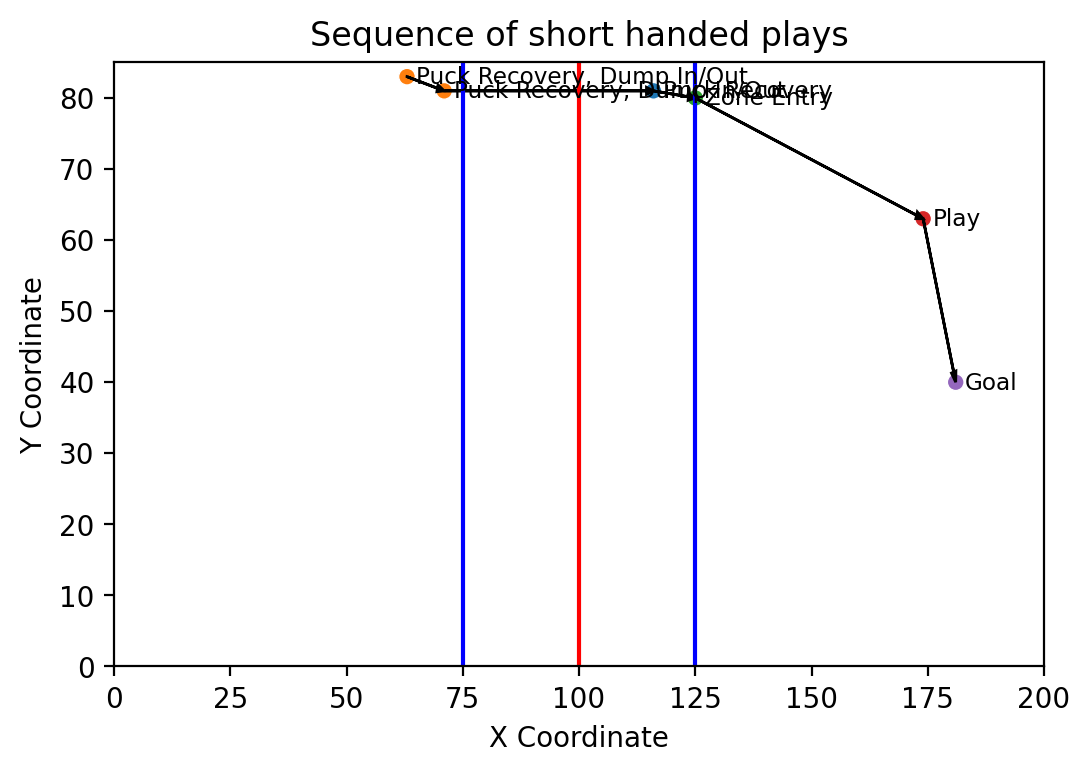

In [17]:
g = sns.scatterplot(data=myseq, x='X Coordinate', y='Y Coordinate', hue='Event', legend=False)
# draw arrows between plays
for i in range(len(myseq) - 1):
    r = myseq.iloc[i]
    r1 = myseq.iloc[i + 1]
    g.axes.arrow(
        r['X Coordinate'], r['Y Coordinate'], 
        r1['X Coordinate'] - r['X Coordinate'],
        r1['Y Coordinate'] - r['Y Coordinate'],
        length_includes_head=True, 
        head_width=1,
        fc='black'
    )
# label plays
for l in range(myseq.shape[0]):
    if l < myseq.shape[0] - 1:
        if (
            (myseq['X Coordinate'].iloc[l] == myseq['X Coordinate'].iloc[l + 1]) &
            (myseq['Y Coordinate'].iloc[l] == myseq['Y Coordinate'].iloc[l + 1])
        ):
            continue
    if l > 0:
        if (
            (myseq['X Coordinate'].iloc[l] == myseq['X Coordinate'].iloc[l - 1]) &
            (myseq['Y Coordinate'].iloc[l] == myseq['Y Coordinate'].iloc[l - 1])
        ):
            g.text(
                myseq['X Coordinate'].iloc[l] + 2,
                myseq['Y Coordinate'].iloc[l] - 1, 
                myseq['Event'].iloc[l - 1] + ', ' + myseq['Event'].iloc[l],
                horizontalalignment='left',
                size='small',
                color='black'
            )
            continue
    g.text(
        myseq['X Coordinate'].iloc[l] + 2,
        myseq['Y Coordinate'].iloc[l] - 1,
        myseq['Event'].iloc[l],
        horizontalalignment='left',
        size='small',
        color='black'
    )
g.set_xlim(0, 200)
g.set_ylim(0, 85)
g.axvline(75, 0, 1, color='blue')
g.axvline(100, 0, 1, color='red')
g.axvline(125, 0, 1, color='blue')
plt.title("Sequence of short handed plays")
plt.show(g)